## Create a Model and use it with and without smote to see the differences of the results

### Imports and Load data

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('../assets/final/data.csv')

def getXy(df):
    # inputs
    X = df.drop(["paid"], axis=1)
    # target
    y = df["paid"]
    # invert the positive and negative classes to make analysis easier
    y = y.map(lambda x: 0 if x == 1 else 1)
    return (X, y)

## Scale Data

It may be necessary to scale data to obtain better results on distance-based models: K-NN and SVC. This doesn't affect tree-based algorithms so we do it here.

We'll do z-score normalization since its not sensitive to outliers

In [42]:
from sklearn import preprocessing

X, y = getXy(data)

scaler = preprocessing.StandardScaler().fit(X)

X_scaled = scaler.transform(X)


### Define Classifiers

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

clfs = {
    "dt":  {"name": "Decision tree", "base": DecisionTreeClassifier(random_state=42), "scale": False, "grid": {}, "clfs": {}},
    "knn": {"name": "K-NN", "base": KNeighborsClassifier(), "scale": True, "grid": {}, "clfs": {}},
    "svm": {"name": "SVC", "base": SVC(probability=True, random_state=42), "scale": True, "grid": {}, "clfs": {}},
    "lr":  {"name": "Logistic Regression", "base": LogisticRegression(random_state=42), "scale": True, "grid": {}, "clfs": {}},
    "nb":  {"name": "Naive Bayes", "base": GaussianNB(), "scale": False, "grid": {}, "clfs": {}},
    "nn":   {"name": "Neural Network", "base": MLPClassifier(random_state=42), "scale": True, "grid": {}, "clfs": {}},
    "rf":  {"name": "Random Forest", "base": RandomForestClassifier(random_state=42), "scale": False, "grid": {}, "clfs": {}},
}

Note: Although the Probability parameter of the SVC can lead to worse results, it is still passed, so we can get the label probabilities later.


### First model with imbalance data


In [44]:
k = 5
kr = 3
cv = RepeatedStratifiedKFold(n_splits=k, n_repeats=kr, random_state=0)

scoring = {"accuracy": "accuracy",
           "precision": "precision",
           "recall": "recall",
           "f1": "f1",
           "roc_auc": "roc_auc"}

# save classifier information in DataFrame: name, score, fit_time, score_time
baseline_df = pd.DataFrame()
for clf_id in clfs:
    clf_entry = clfs[clf_id]
    Xt = X_scaled if clf_entry["scale"] else X 
    scores = cross_validate(clf_entry["base"], Xt, y, scoring=scoring, cv=cv) #n_jobs=configNJobs)
    info = scores | {"classifier": [clf_entry["name"]] * (k * kr)}
    baseline_df = baseline_df.append(pd.DataFrame(info))

baseline_df.head()

C:\Users\ruial\AppData\Local\Temp\ipykernel_3488\591731349.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  baseline_df = baseline_df.append(pd.DataFrame(info))
C:\Users\ruial\AppData\Local\Temp\ipykernel_3488\591731349.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  baseline_df = baseline_df.append(pd.DataFrame(info))
C:\Users\ruial\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ruial\AppData\Local\Temp\ipykernel_3488\591731349.py:18: FutureWarning: The frame.append method

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,classifier
0,0.006002,0.016001,0.863636,0.600000,0.300000,0.400000,0.632143,Decision tree
1,0.003997,0.007004,0.848485,0.444444,0.444444,0.444444,0.678363,Decision tree
2,0.003997,0.007002,0.833333,0.428571,0.666667,0.521739,0.763158,Decision tree
3,0.003001,0.006999,0.769231,0.285714,0.444444,0.347826,0.632937,Decision tree
4,0.002998,0.007000,0.846154,0.454545,0.555556,0.500000,0.724206,Decision tree


### Accuracy

<AxesSubplot:title={'center':'Accuracy'}, xlabel='classifier', ylabel='test_accuracy'>

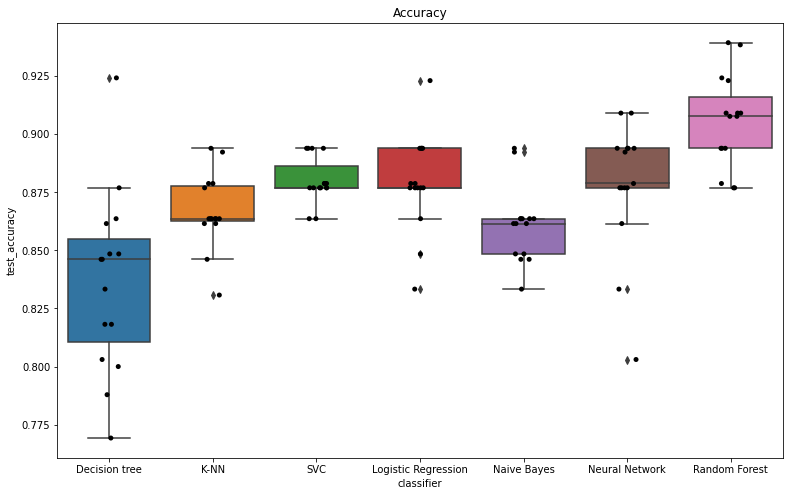

In [45]:
plt.figure(figsize=(13, 8))
sb.boxplot(x="classifier", y="test_accuracy", data=baseline_df).set(title="Accuracy")
sb.stripplot(x='classifier', y='test_accuracy', data=baseline_df, jitter=True, color='black')

### Precision

<AxesSubplot:title={'center':'Precision'}, xlabel='classifier', ylabel='test_precision'>

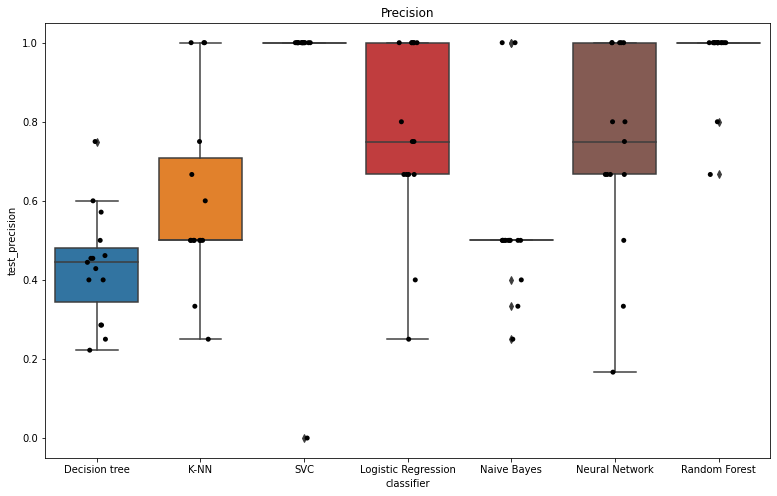

In [46]:
plt.figure(figsize=(13, 8))
sb.boxplot(x="classifier", y="test_precision", data=baseline_df).set(title="Precision")
sb.stripplot(x='classifier', y='test_precision', data=baseline_df, jitter=True, color='black')

The low precision of the SVC and K-NN might be an indicator that the model is trying to predict 0 for all classes.


### Recall

<AxesSubplot:title={'center':'Recall'}, xlabel='classifier', ylabel='test_recall'>

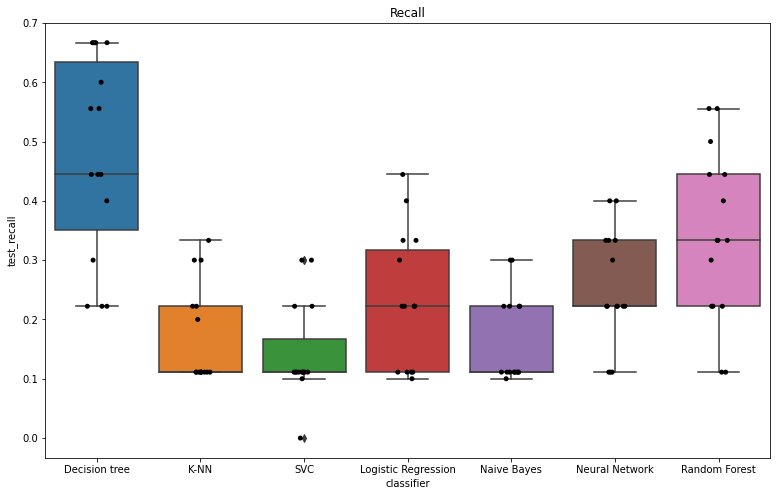

In [47]:
plt.figure(figsize=(13, 8))
sb.boxplot(x="classifier", y="test_recall", data=baseline_df).set(title="Recall")
sb.stripplot(x='classifier', y='test_recall', data=baseline_df, jitter=True, color='black')

As expected, the SVC and K-NN performed picked up (almost) none the true positives (loan rejections) in the dataset. 

This is reinforces the hypotheses about the precision above. The other 2 models appear to be much better at discerning the positive class.

### F1-Score

<AxesSubplot:title={'center':'F1-score'}, xlabel='classifier', ylabel='test_f1'>

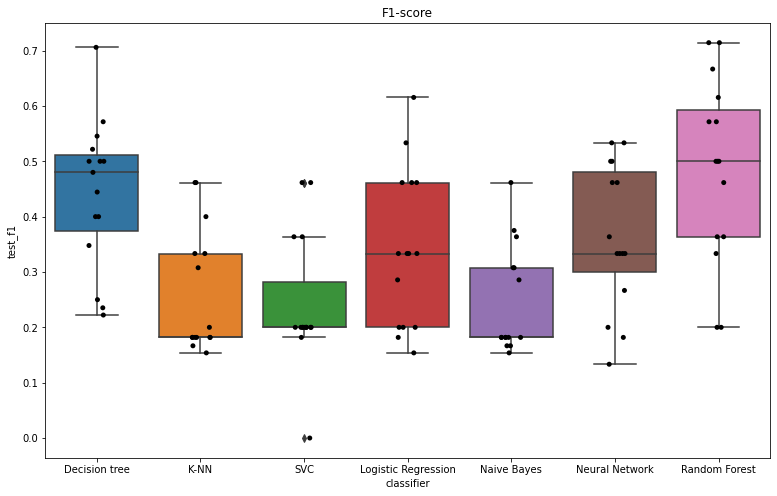

In [48]:
plt.figure(figsize=(13, 8))
sb.boxplot(x="classifier", y="test_f1", data=baseline_df).set(title="F1-score")
sb.stripplot(x='classifier', y='test_f1', data=baseline_df, jitter=True, color='black')

### Roc-Curve Area Under the Curve

<AxesSubplot:title={'center':'ROC-AUC'}, xlabel='classifier', ylabel='test_roc_auc'>

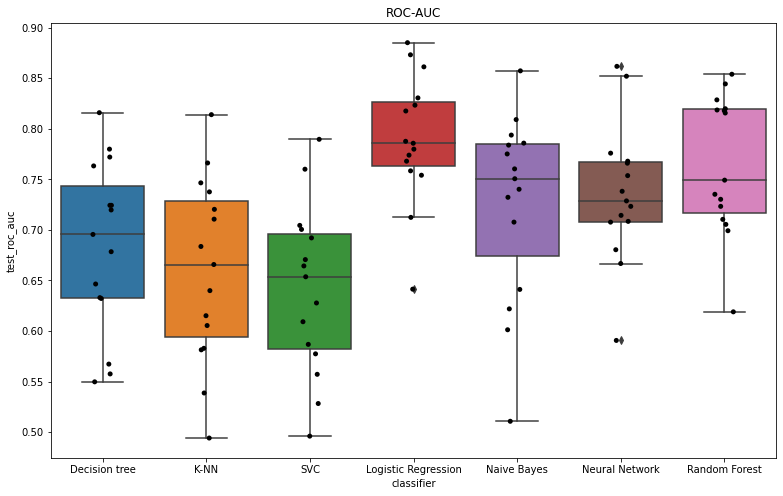

In [49]:
plt.figure(figsize=(13, 8))
sb.boxplot(x="classifier", y="test_roc_auc", data=baseline_df).set(title="ROC-AUC")
sb.stripplot(x='classifier', y='test_roc_auc', data=baseline_df, jitter=True, color='black')

### Fit and score times


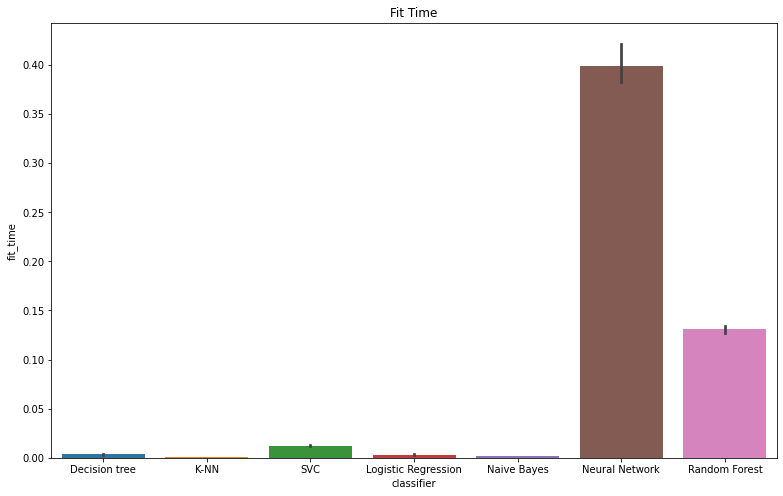

In [50]:
plt.figure(figsize=(13, 8))
sb.barplot(x="classifier", y="fit_time", data=baseline_df).set(title="Fit Time");

[Text(0.5, 1.0, 'Score Time')]

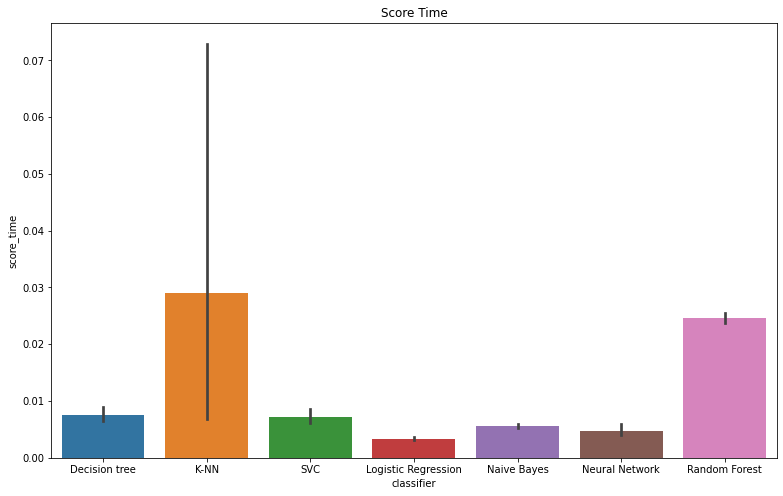

In [51]:
plt.figure(figsize=(13, 8))
sb.barplot(x="classifier", y="score_time", data=baseline_df).set(title="Score Time")

[Text(0.5, 1.0, 'Total Time')]

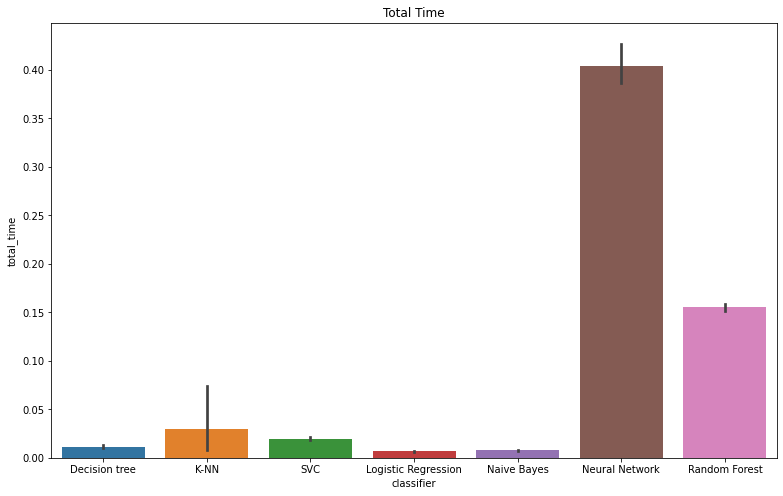

In [52]:
baseline_df["total_time"] = baseline_df["score_time"] + baseline_df["fit_time"]

plt.figure(figsize=(13, 8))
sb.barplot(x="classifier", y="total_time", data=baseline_df).set(title="Total Time")

## Parameter tuning

We will now tune the parameters, so we can find which is the best classifier to use in our problem.

In [53]:
from matplotlib import gridspec
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

def grid_search(clf, parameter_grid, scale=False, n_jobs=-1):
    grid_search = GridSearchCV(clf,
                               param_grid=parameter_grid,
                               cv=cv,
                               scoring="roc_auc",
                               n_jobs=n_jobs)
    Xt = X_scaled if scale else X 

    grid_search.fit(Xt, y)
    # output info
    print("Best score: {}".format(grid_search.best_score_))
    print("Best parameters: {}".format(grid_search.best_params_))
    clf = grid_search.best_estimator_

    # plots
    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=(20, 16))
    ax = plt.subplot(gs[0, 0])
    sb.histplot(x="mean_test_score", data=grid_search.cv_results_, kde=True, ax=ax)
    ax = plt.subplot(gs[0, 1])
    sb.boxplot(x="mean_test_score", data=grid_search.cv_results_, ax=ax)
    # roc and prec-recall curves
    ax = plt.subplot(gs[1, 0])
    RocCurveDisplay.from_estimator(clf, Xt, y, pos_label=1, ax=ax)
    ax = plt.subplot(gs[1, 1])
    PrecisionRecallDisplay.from_estimator(clf, Xt, y, ax=ax)
    
    # return the best classifier
    return clf

def grid_search_clf(id):
    clf = grid_search(clfs[id]["base"], clfs[id]["grid"], clfs[id]["scale"])
    clfs[id]["clfs"]["no oversampling"] = clf

### Support vector classifier


Best score: 0.7570307713728767
Best parameters: {'C': 0.01, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}


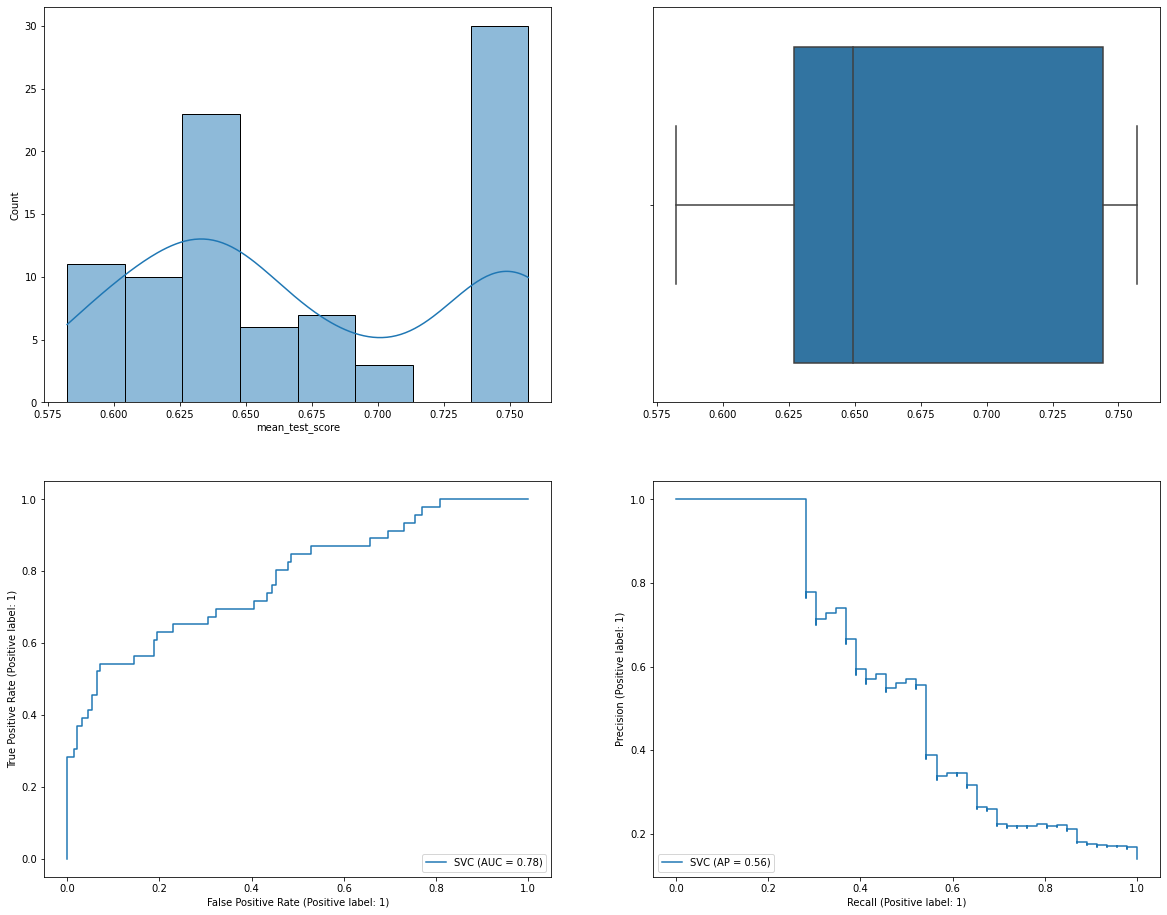

In [54]:
clfs["svm"]["grid"] = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    "degree": [2, 3, 4],
    "gamma": ["auto", "scale"],
    "kernel": ["linear", "poly", "rbf"],
}

grid_search_clf("svm")

### Logistic regression classifier


Best score: 0.7909502923976609
Best parameters: {'C': 0.1, 'solver': 'newton-cg'}


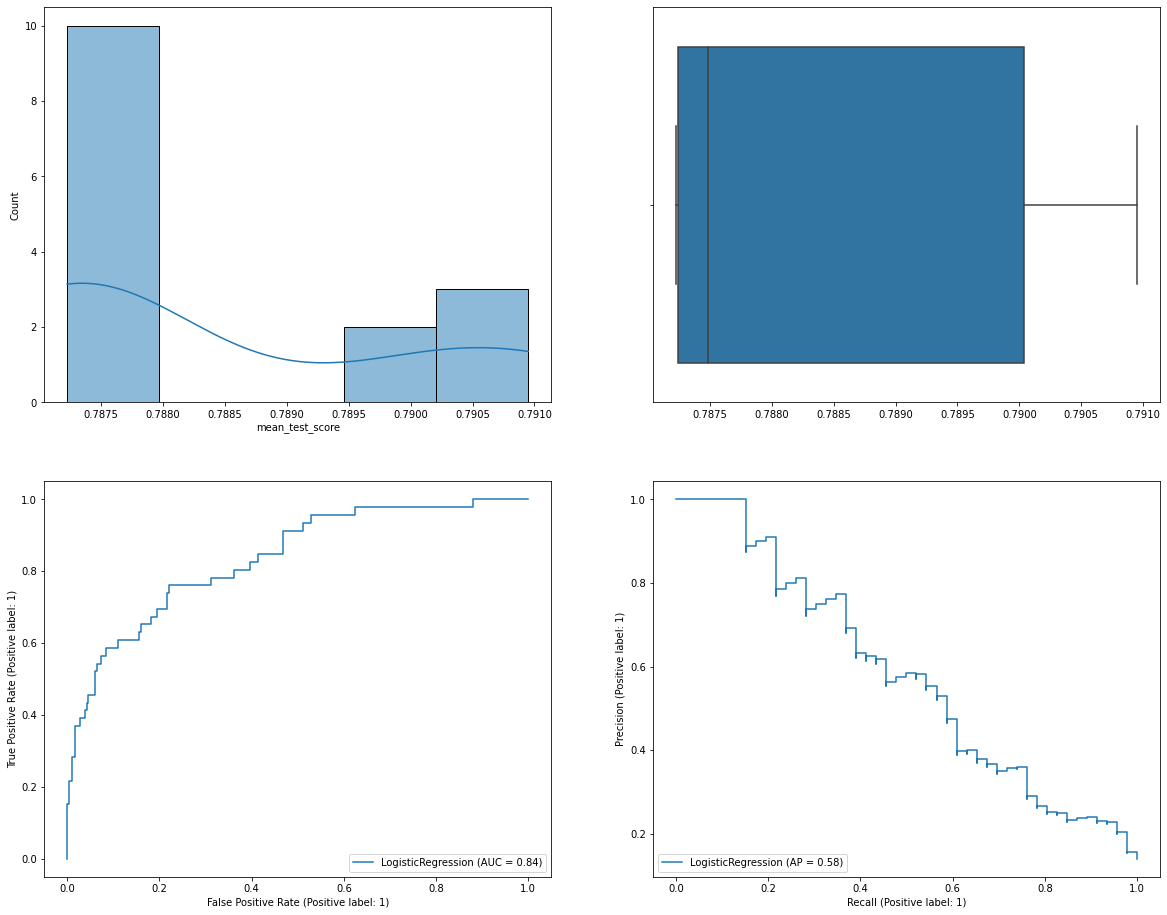

In [55]:
# For small datasets, ‘liblinear’ is a good choice,
# whereas ‘sag’ and ‘saga’ are faster for large ones;
# For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’
# handle multinomial loss;
#‘liblinear’ is limited to one-versus-rest schemes.

clfs["lr"]["grid"] = {
    "C": [0.1, 1, 10, 100, 1000],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
}

grid_search_clf("lr")

### Random forest classifier


Best score: 0.7646089761440639
Best parameters: {}


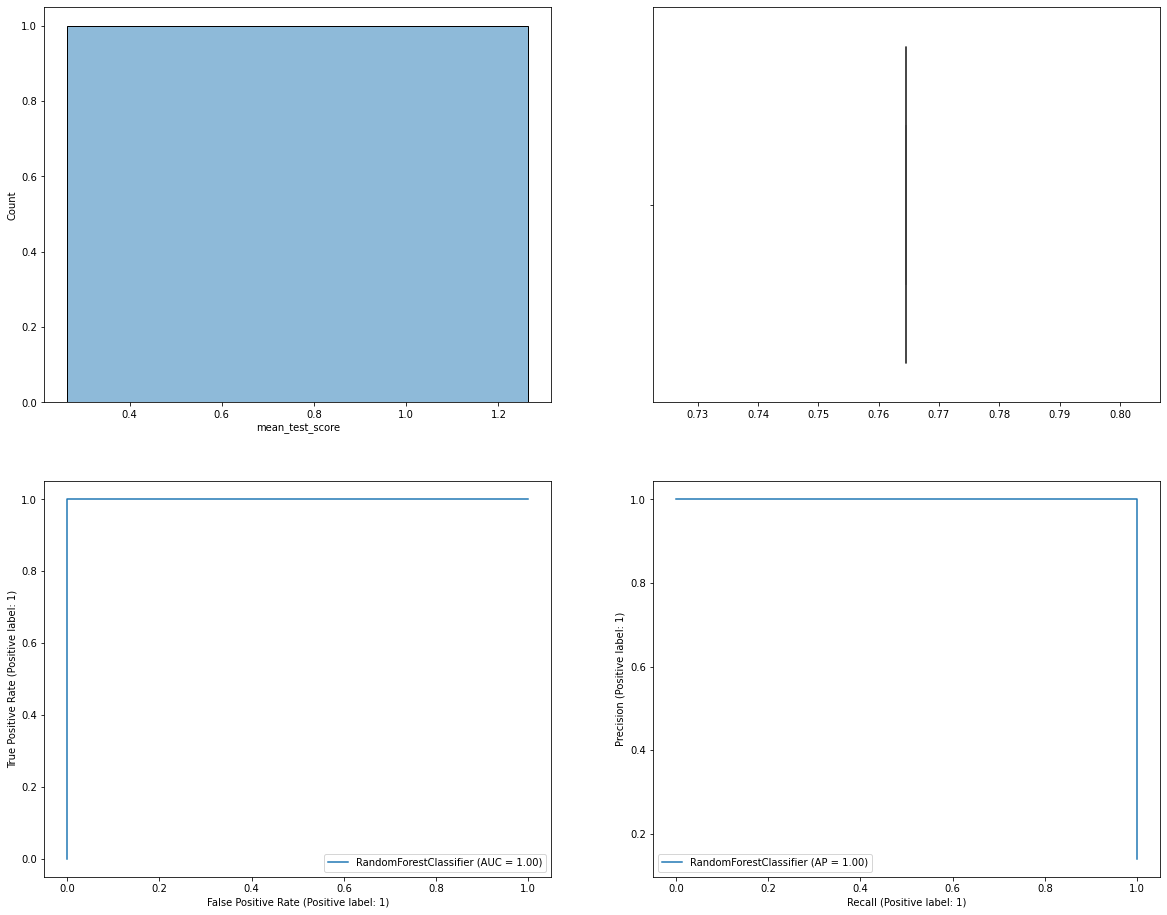

In [56]:
'''
clfs["rf"]["grid"] = {
    "n_estimators": [75, 100, 150, 200],
    "criterion": ["gini", "entropy"],
    "max_depth": np.arange(2, 5, 1),
    "max_features": ["sqrt", "log2", None],
}
'''
clfs["rf"]["grid"] = {}

grid_search_clf("rf")

The main attributes to test with the Random Forest are the max depth, max features, and the number of estimators of the model. Increasing the max features and max depth of the trees is likely to increase the score, but worsen it when classifying data that it hasn't seen before (test data).

The model is trying to use as many estimators and depth as possible. We won't allow that as that is likelly to increase the test error (even though it decreases the train error).



### Neural Networks


C:\Users\ruial\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best score: 0.7920637241251277
Best parameters: {'activation': 'tanh', 'alpha': 0.0001, 'learning_rate': 'constant', 'solver': 'sgd'}


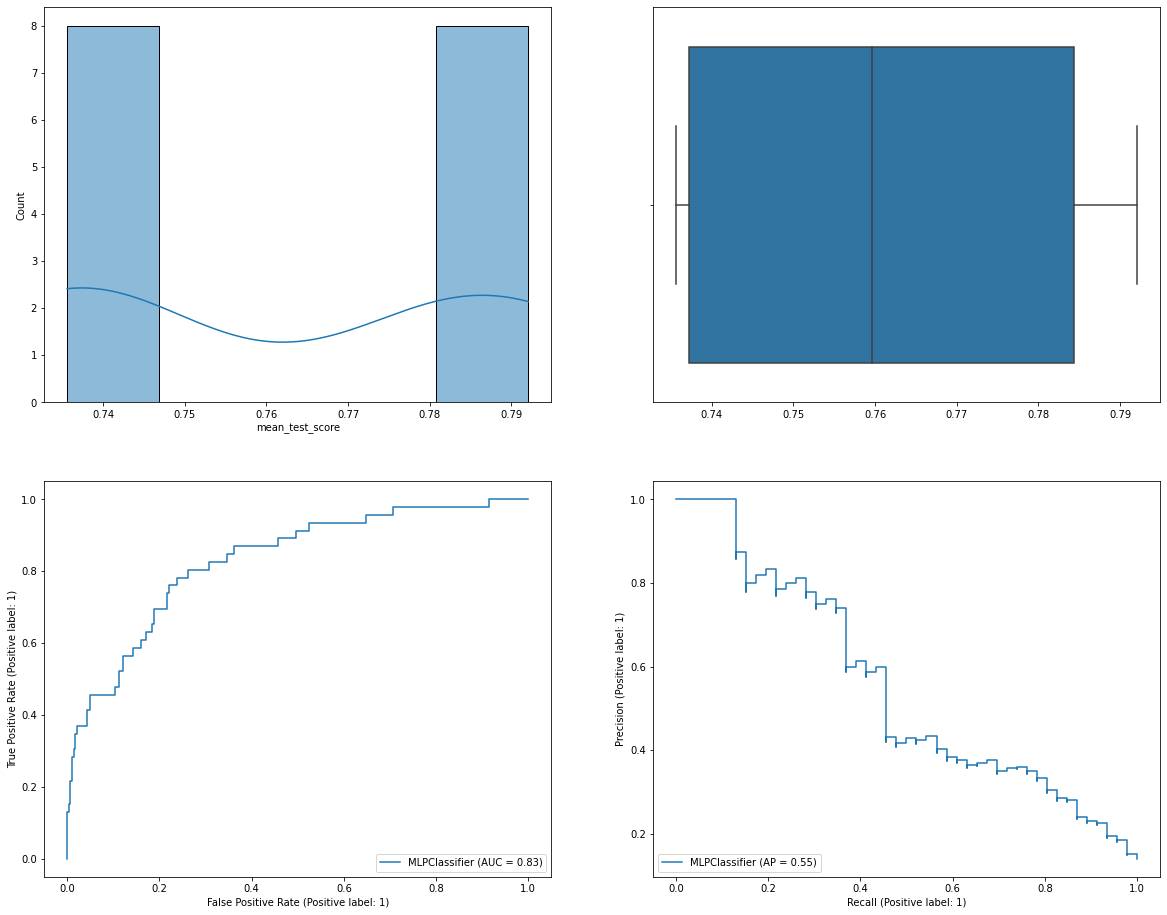

In [57]:
clfs["nn"]["grid"] = {
    "activation": ["tanh", "relu"],
    "solver": ["sgd", "adam"],
    "alpha": [0.0001, 0.05],
    "learning_rate": ["constant", "adaptive"],
}

grid_search_clf("nn")

## Oversampling

Since the two classes are imbalanced, it can prove useful to apply over/undersampling processes.

In this case, it was decided to oversample the minority class (as opposed to undersampling the majority), because the number of entries on the dataset is very low.


In [58]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

def grid_search_oversample(clf, parameter_grid, smote, scale=False):
    imba_pipeline = Pipeline([("os", smote), ("model", clf)])
    prefixed_param_grid = {"os__sampling_strategy": [0.3, 0.4, 0.5, 0.8, 1.0]}
    for key in parameter_grid:
        prefixed_param_grid["model__" + key] = parameter_grid[key]
    return grid_search(imba_pipeline, prefixed_param_grid, scale, n_jobs=-1)


def os_smote(id, clf = None):
    smote = SMOTE(random_state=0)
    clf = grid_search_oversample(clfs[id]["base"], clfs[id]["grid"],
                                 smote, clfs[id]["scale"])
    clfs[id]["clfs"]["smote"] = clf

### Support vector classifier


Best score: 0.7900355054302423
Best parameters: {'model__C': 10, 'model__degree': 2, 'model__gamma': 'auto', 'model__kernel': 'linear', 'os__sampling_strategy': 0.3}


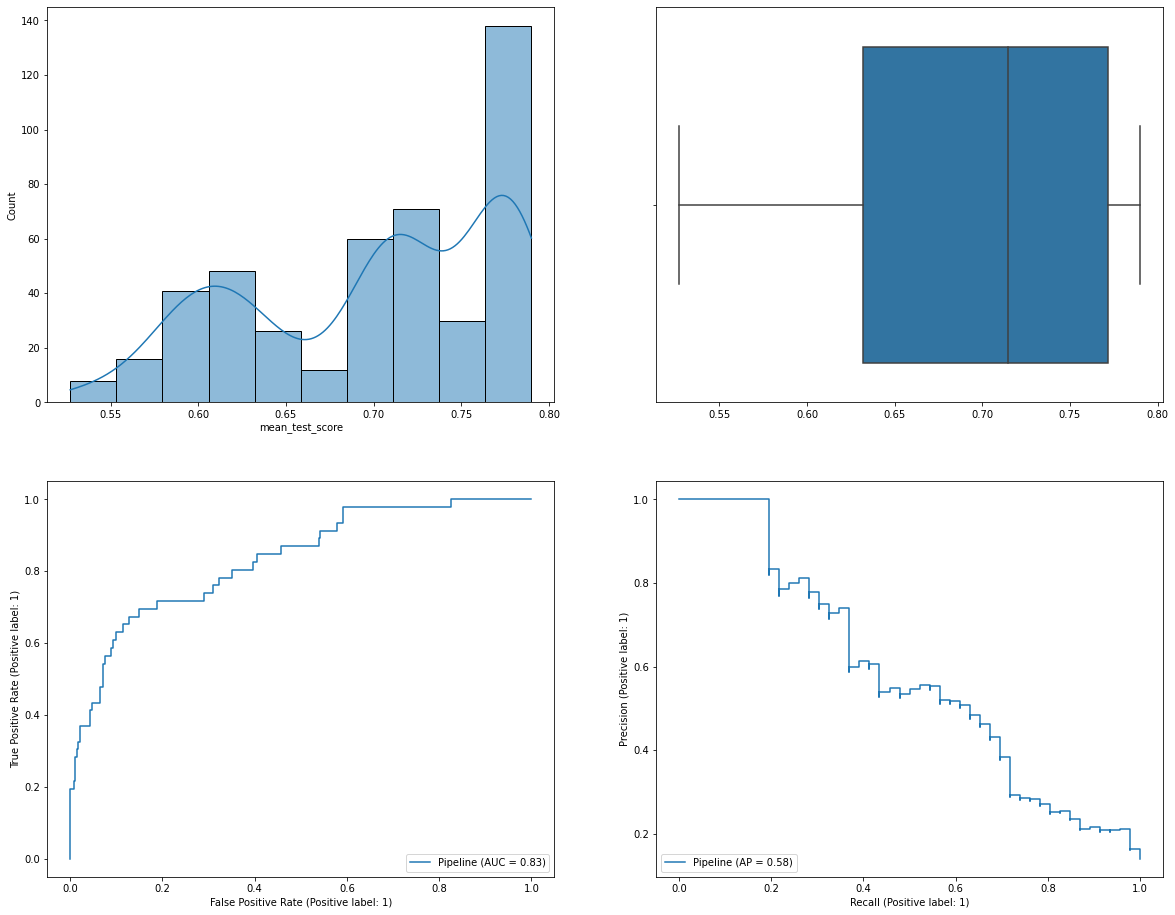

In [59]:
os_smote("svm")


### Logistic Regression classifier


Best score: 0.7888902812587022
Best parameters: {'model__C': 0.1, 'model__solver': 'liblinear', 'os__sampling_strategy': 0.5}


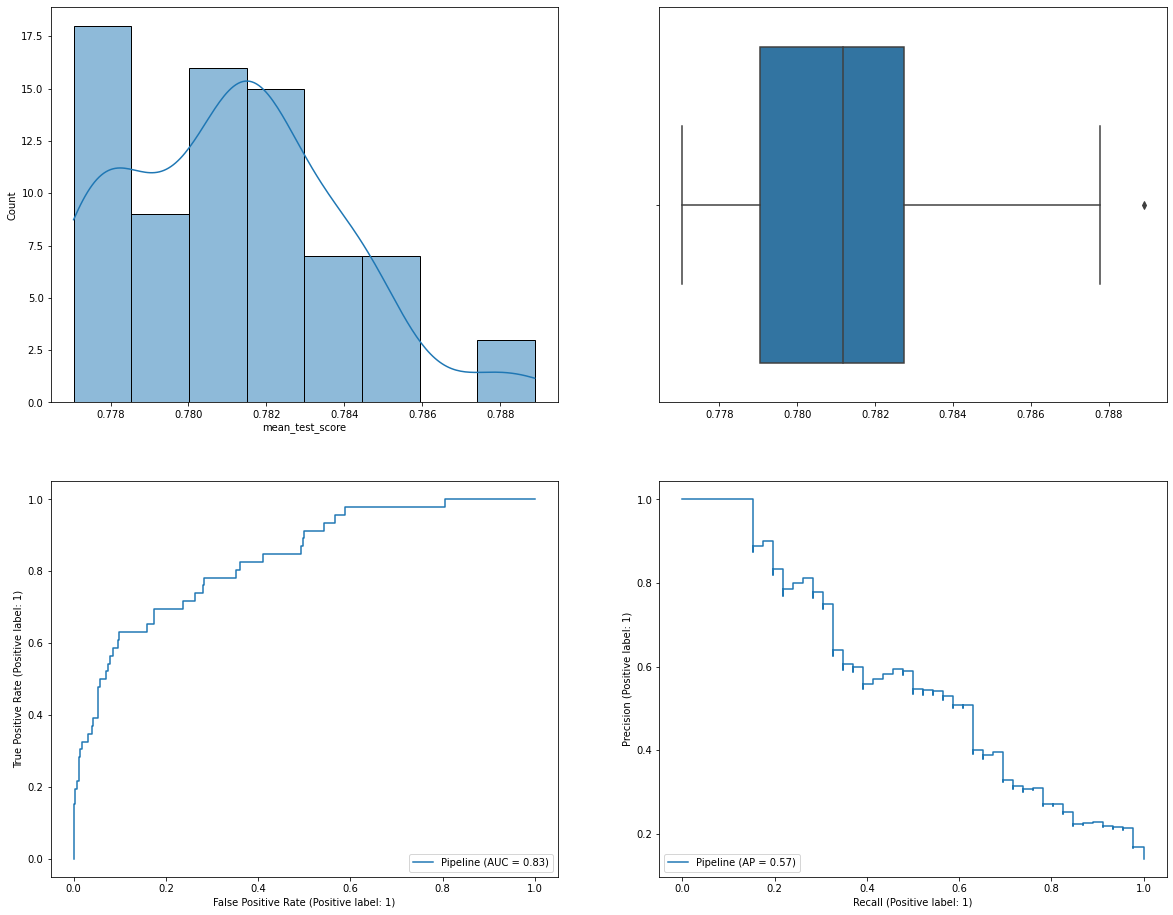

In [60]:
os_smote("lr")


### Random forest classifier


Best score: 0.8005205142485844
Best parameters: {'os__sampling_strategy': 1.0}


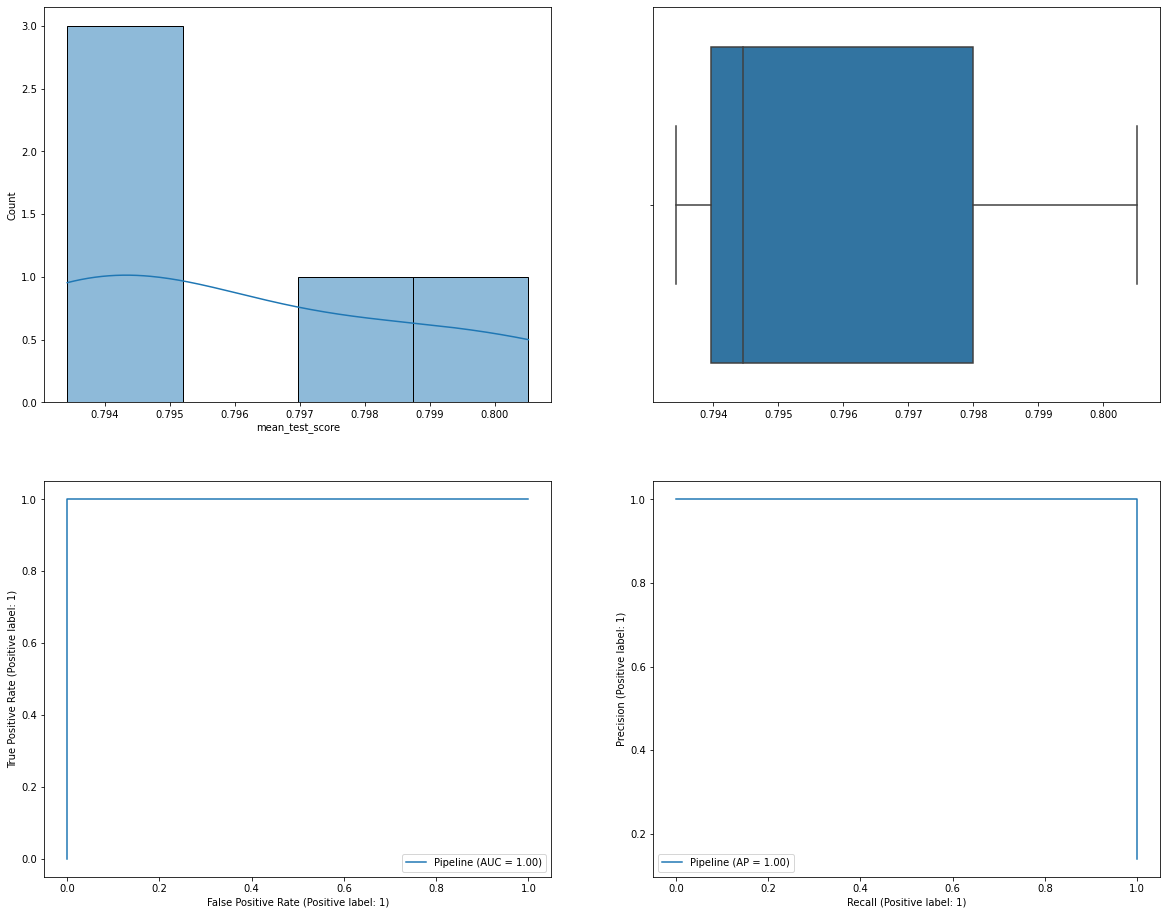

In [61]:
os_smote("rf")


### Neural Networks

C:\Users\ruial\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best score: 0.7903288313376033
Best parameters: {'model__activation': 'tanh', 'model__alpha': 0.0001, 'model__learning_rate': 'constant', 'model__solver': 'sgd', 'os__sampling_strategy': 0.5}


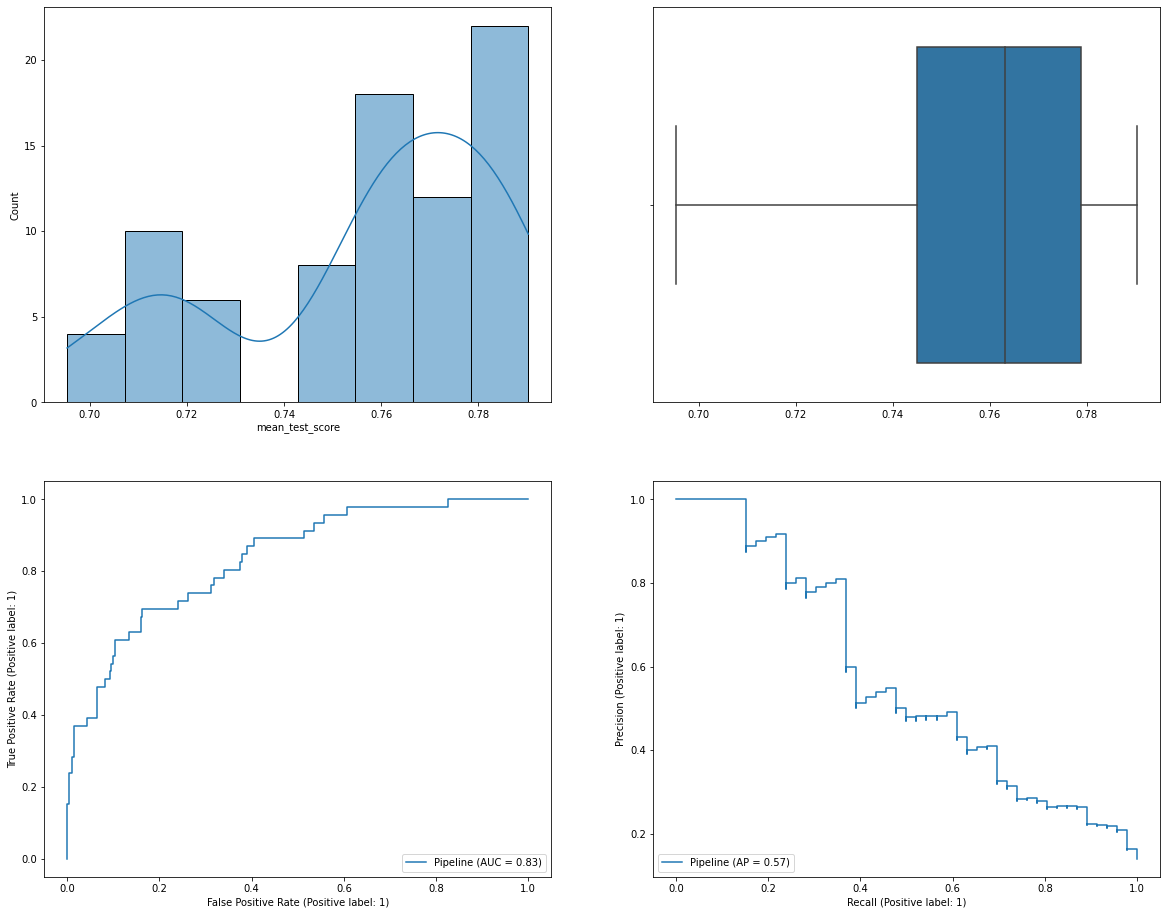

In [62]:
os_smote("nn")